In [1]:
!pip install remotezip

In [3]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00


In [4]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [50]:
def list_files_per_class(zip_url):
    """
    List the files in each class of the dataset given the zip URL.

    Args:
        zip_url: URL from which the files can be unzipped.

    Return:
        files: List of files in each of the classes.
    """
    files = []
    with rz.RemoteZip(zip_url) as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs


def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to be resized and padded.
      output_size: Pixel size of the output frame image (height, width).

    Returns:
      Formatted frame with padding of specified output size.
    """
    frame = frame.astype(float) / 255.0
    frame = np.transpose(frame, (2, 0, 1))
    transform = T.Compose([
        T.Resize(output_size)
    ])
    frame = transform(torch.from_numpy(frame))
    return frame


def set_frame_step(video_length, n_frames):
    frame_step = math.floor(video_length / n_frames)
    return frame_step


def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step=15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  if frame_step < 0:
    frame_step = set_frame_step(video_length, n_frames)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for i in range(n_frames - 1):
    for j in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)#[..., [2, 1, 0]]
  return np.transpose(result, (1, 2, 3, 0))


class FrameGeneratorDataset(Dataset):
    def __init__(self, path, n_frames, training=False, frame_step=15):
        """
        Returns a set of frames with their associated label.

        Args:
          path: Directory path containing video files.
          n_frames: Number of frames to extract from each video.
          training: Boolean indicating if this is the training dataset (to enable shuffling).
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.frame_step = frame_step

        # Get all class names and assign a unique ID to each
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

        # Get video file paths and their corresponding class labels
        self.video_paths, self.classes = self.get_files_and_class_names()

        # Shuffle the pairs if in training mode
        if self.training:
            data = list(zip(self.video_paths, self.classes))
            random.shuffle(data)
            self.video_paths, self.classes = zip(*data)

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __len__(self):
        # Return the number of video files available
        return len(self.video_paths)

    def __getitem__(self, idx):
        """
        Retrieve frames and the label for a given video index.

        Args:
          idx: Index of the video to retrieve.

        Returns:
          A tuple (frames, label) where frames are the extracted frames from the video,
          and label is the encoded class label.
        """
        path = self.video_paths[idx]
        class_name = self.classes[idx]

        # Extract frames from the video file
        video_frames = frames_from_video_file(path, self.n_frames, frame_step=self.frame_step)

        # Get label by encoding the class name
        label = self.class_ids_for_name[class_name]

        # Convert frames and label to tensors
        video_frames = torch.tensor(video_frames, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.int64)

        return video_frames, label

In [ ]:
def select_frames_sift(video_path: str) -> List[int]:
    """
    Select frames using the SIFT algorithm.

    Args:
        video_path (str): Path to the video file.

    Returns:
        List[int]: List of selected frame indices.
    """
    vidcap = cv2.VideoCapture(video_path)
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    feature_detector = cv2.SIFT_create()
    feature_matcher = cv2.BFMatcher()

    _, prev_des = None, None
    frame_diffs = []

    for count in range(frame_count):
        ret, frame = vidcap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (width, height))

        kp, des = feature_detector.detectAndCompute(gray, None)

        if prev_des is not None:
            matches = feature_matcher.knnMatch(prev_des, des, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
            diff_sum = len(good_matches)
            frame_diffs.append((count, diff_sum, cv2.Laplacian(gray, cv2.CV_64F).var()))

        _, prev_des = kp, des

    vidcap.release()

    # Sort frames by the number of good matches (difference) and sharpness
    frame_diffs.sort(key=lambda x: (x[1], -x[2]))

    # Select top frames_per_clip frames with the least number of good matches
    selected_frames_ids = [frame_diffs[i][0] for i in range(min(self.frames_per_clip, len(frame_diffs)))]

    return selected_frames_ids

In [7]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 10,
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [00:29<00:00, 10.31it/s]


val :


100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


test :


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


In [51]:
# Parameters
n_frames = 10
batch_size = 8

# Dataset paths
train_dataset = FrameGeneratorDataset(subset_paths['train'], n_frames, training=True, frame_step=-1)
val_dataset = FrameGeneratorDataset(subset_paths['val'], n_frames, training=False, frame_step=-1)
test_dataset = FrameGeneratorDataset(subset_paths['test'], n_frames, training=False, frame_step=-1)

# DataLoaders with batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [53]:
class Conv2Plus1D(nn.Module):
    def __init__(self, input_channels, filters, kernel_size, device):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension.

        Args:
          filters (int): Number of filters in each convolutional layer.
          kernel_size (tuple): Kernel size for the convolution in (depth, height, width).
        """
        super(Conv2Plus1D, self).__init__()

        padding_spatial = (0, kernel_size[1] // 2, kernel_size[2] // 2)
        padding_temporal = (kernel_size[0] // 2, 0, 0)

        # Sequential container for spatial and temporal convolution
        self.seq = nn.Sequential(
            # Spatial decomposition
            nn.Conv3d(in_channels=input_channels,
                      out_channels=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding_spatial,
                      device=device),
            # Temporal decomposition
            nn.Conv3d(in_channels=filters,
                      out_channels=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding_temporal,
                      device=device)
        )

    def forward(self, x):
        return self.seq(x)

In [54]:
class ResidualMain(nn.Module):
    """
    Residual block of the model with convolution, layer normalization, and ReLU activation.
    """
    def __init__(self, input_channels, filters, kernel_size, height, width, device):
        super(ResidualMain, self).__init__()
        self.conv1 = Conv2Plus1D(input_channels=input_channels, filters=filters, kernel_size=kernel_size, device=device)
        self.norm = nn.LayerNorm(normalized_shape=(filters, ), eps=1e-3, device=device)
        self.conv2 = Conv2Plus1D(input_channels=filters, filters=filters, kernel_size=kernel_size, device=device)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolution
        x = self.conv1(x)
        x = x.permute(0, 4, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 4, 2, 3, 1)

        # Apply ReLU
        x = self.relu(x)

        # Second convolution
        x = self.conv2(x)

        x = x.permute(0, 4, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 4, 2, 3, 1)

        return x

In [55]:
import torch
import torch.nn as nn

class Project(nn.Module):
    """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
    """
    def __init__(self, units, height, width, device):
        super(Project, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=units[0], out_features=units[1], device=device),  # Linear projection
            nn.LayerNorm(units[1], device=device)
        )

    def forward(self, x):
        return self.seq(x)


In [56]:
import torch.nn.functional as F
import einops

def resize_video(video, height, width):
    """
    Resize the tensor using einops and PyTorch's interpolation.

    Args:
      video (torch.Tensor): Tensor representation of the video, as a batch of frames.

    Returns:
      torch.Tensor: Resized video tensor with the new height and width.
    """
    # Parse the shape and rearrange for resizing
    old_shape = einops.parse_shape(video, 'b c h w t')
    images = einops.rearrange(video, 'b c h w t -> b t h w c')
    images = einops.rearrange(images, 'b t h w c -> (b t) h w c')

    # Resize images using interpolate
    images = F.interpolate(images.permute(0, 3, 1, 2), size=(height, width), mode='bilinear', align_corners=False)
    images = images.permute(0, 2, 3, 1)  # Convert back to (batch, height, width, channels)

    # Reshape back to video format
    videos = einops.rearrange(images, '(b t) h w c -> b t h w c', t=old_shape['t'])
    output = einops.rearrange(videos, 'b t h w c -> b c h w t')
    return output


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VideoModel(nn.Module):
    def __init__(self, height, width, device):
        super(VideoModel, self).__init__()
        self.height = height
        self.width = width
        kernel_size = (3,3,3)

        self.conv = Conv2Plus1D(input_channels=3, filters=16, kernel_size=(3, 7, 7), device=device)
        self.norm = nn.LayerNorm(normalized_shape=(16, ), eps=1e-3, device=device)
        self.relu = nn.ReLU()

        self.residual1 = ResidualMain(16, 16, kernel_size, self.height // 2, self.width // 2, device)
        self.residual2 = ResidualMain(16, 32, kernel_size, self.height // 4, self.width // 4, device)
        self.residual3 = ResidualMain(32, 64, kernel_size, self.height // 8, self.width // 8, device)
        self.residual4 = ResidualMain(64, 128, kernel_size, self.height // 16, self.width // 16, device)

        self.project1 = Project(units=(16, 32), height=self.height // 2, width=self.width // 2, device=device)
        self.project2 = Project(units=(32, 64), height=self.height // 4, width=self.width // 4, device=device)
        self.project3 = Project(units=(64, 128), height=self.height // 8, width=self.width // 8, device=device)

        # Pooling and Output Layers
        self.global_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 10)  # Adjust the input to `Linear` based on the final channel size

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 4, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 4, 2, 3, 1)
        x = self.relu(x)

        x = resize_video(x, self.height // 2, self.width // 2)
        out = self.residual1(x)
        x = torch.add(x, out)

        resized_x = resize_video(x, self.height // 4, self.width // 4)
        projected_x = self.project1(resized_x.permute(0, 4, 2, 3, 1))
        residual_x = self.residual2(resized_x)
        x = torch.add(projected_x.permute(0, 4, 2, 3, 1), residual_x)
        
        resized_x = resize_video(x, self.height // 8, self.width // 8)
        projected_x = self.project2(resized_x.permute(0, 4, 2, 3, 1))
        residual_x = self.residual3(resized_x)
        x = torch.add(projected_x.permute(0, 4, 2, 3, 1), residual_x)
        
        resized_x = resize_video(x, self.height // 16, self.width // 16)
        projected_x = self.project3(resized_x.permute(0, 4, 2, 3, 1))
        residual_x = self.residual4(resized_x)
        x = torch.add(projected_x.permute(0, 4, 2, 3, 1), residual_x)

        # Global average pooling and flatten
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [58]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for frames, labels in val_loader:
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy
    

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=50):
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for frames, labels in train_loader:
            frames, labels = frames.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            
        train_accuracy = correct / total
        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        train_loss = running_loss / len(train_loader)

        if val_accuracy > best:
              torch.save(model.state_dict(), "best.pt")
              best = val_accuracy
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return history

In [59]:
import torch.optim as optim

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VideoModel(height=HEIGHT, width=WIDTH, device=device).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [60]:
model

VideoModel(
  (conv): Conv2Plus1D(
    (seq): Sequential(
      (0): Conv3d(3, 16, kernel_size=(1, 7, 7), stride=(1, 1, 1), padding=(0, 3, 3))
      (1): Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
    )
  )
  (norm): LayerNorm((16,), eps=0.001, elementwise_affine=True)
  (relu): ReLU()
  (residual1): ResidualMain(
    (conv1): Conv2Plus1D(
      (seq): Sequential(
        (0): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        (1): Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
      )
    )
    (norm): LayerNorm((16,), eps=0.001, elementwise_affine=True)
    (conv2): Conv2Plus1D(
      (seq): Sequential(
        (0): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        (1): Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
      )
    )
    (relu): ReLU()
  )
  (residual2): ResidualMain(
    (conv1): Conv2Plus1D(
      (seq): Sequential(
  

In [16]:
!pip install torchinfo

In [17]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
VideoModel                               --
├─Conv2Plus1D: 1-1                       --
│    └─Sequential: 2-1                   --
│    │    └─Conv3d: 3-1                  2,368
│    │    └─Conv3d: 3-2                  784
├─LayerNorm: 1-2                         32
├─ReLU: 1-3                              --
├─ResidualMain: 1-4                      --
│    └─Conv2Plus1D: 2-2                  --
│    │    └─Sequential: 3-3              3,104
│    └─LayerNorm: 2-3                    32
│    └─Conv2Plus1D: 2-4                  --
│    │    └─Sequential: 3-4              3,104
│    └─ReLU: 2-5                         --
├─ResidualMain: 1-5                      --
│    └─Conv2Plus1D: 2-6                  --
│    │    └─Sequential: 3-5              7,744
│    └─LayerNorm: 2-7                    64
│    └─Conv2Plus1D: 2-8                  --
│    │    └─Sequential: 3-6              12,352
│    └─ReLU: 2-9                         --
├─Residual

In [61]:
# Training

history = train_model(model, optimizer, criterion, train_loader, val_loader)

Epoch [1/50], Train Loss: 2.3362, Train Acc: 0.1333, Val Loss: 2.1867, Val Acc: 0.1600
Epoch [2/50], Train Loss: 2.2008, Train Acc: 0.1867, Val Loss: 2.1386, Val Acc: 0.2800
Epoch [3/50], Train Loss: 2.1235, Train Acc: 0.2067, Val Loss: 2.0980, Val Acc: 0.2300
Epoch [4/50], Train Loss: 2.0865, Train Acc: 0.2400, Val Loss: 2.0410, Val Acc: 0.2400
Epoch [5/50], Train Loss: 1.9796, Train Acc: 0.2600, Val Loss: 2.0594, Val Acc: 0.2900
Epoch [6/50], Train Loss: 1.9155, Train Acc: 0.2667, Val Loss: 1.9065, Val Acc: 0.2800
Epoch [7/50], Train Loss: 1.8663, Train Acc: 0.3200, Val Loss: 1.8670, Val Acc: 0.2900
Epoch [8/50], Train Loss: 1.7700, Train Acc: 0.3333, Val Loss: 1.7653, Val Acc: 0.3700
Epoch [9/50], Train Loss: 1.7013, Train Acc: 0.3500, Val Loss: 1.8110, Val Acc: 0.2700
Epoch [10/50], Train Loss: 1.7073, Train Acc: 0.3567, Val Loss: 1.6421, Val Acc: 0.3900
Epoch [11/50], Train Loss: 1.6045, Train Acc: 0.4400, Val Loss: 1.6297, Val Acc: 0.4600
Epoch [12/50], Train Loss: 1.5209, Train 

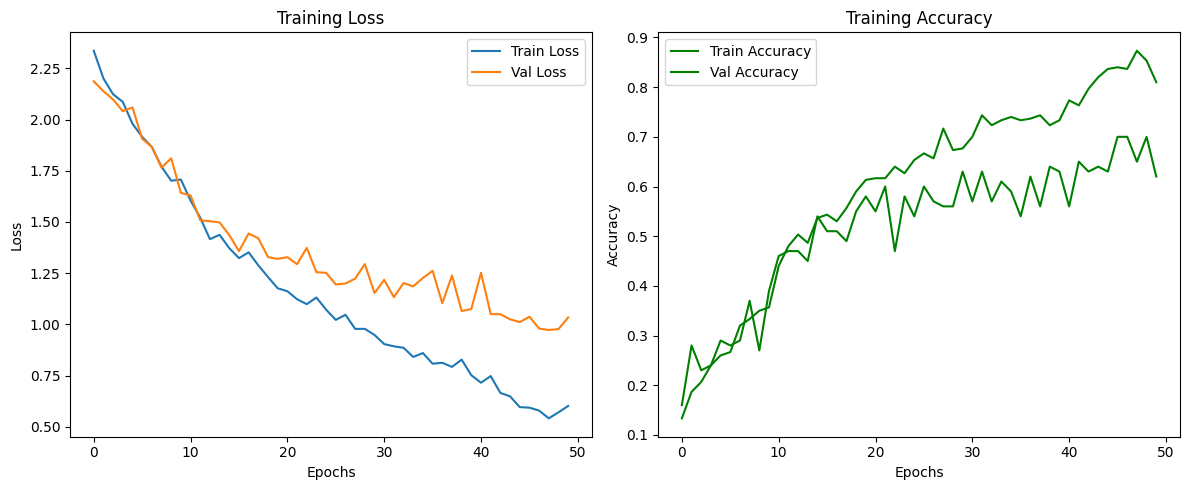

In [71]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting training losses and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label='Train Loss')
plt.plot(history["val_loss"], label='Val Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_accuracy"], label='Train Accuracy', color='green')
plt.plot(history["val_accuracy"], label='Val Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Generate actual and predicted labels
def get_actual_predicted_labels(model, dataset_loader):
    model.eval()
    actual = []
    predicted = []
    all_probas = []
    with torch.no_grad():
        for frames, labels in dataset_loader:
            frames = frames.to(device)
            outputs = model(frames)
            _, preds = torch.max(outputs, 1)
            actual.append(labels.cpu())
            predicted.append(preds.cpu())
            
            # Apply softmax to get probabilities
            probas = F.softmax(outputs, dim=1)
            all_probas.append(probas.cpu())

    # Concatenate all batches into single arrays
    all_probas = torch.cat(all_probas, dim=0).numpy()
    actual = torch.cat(actual, dim=0).numpy()
    predicted = torch.cat(predicted, dim=0).numpy()
    return actual, predicted, all_probas

In [68]:
evaluate_model(model, test_loader, criterion)

(0.9835948118796716, 0.66)

In [69]:
y_true, y_pred, y_proba = get_actual_predicted_labels(model, test_loader)

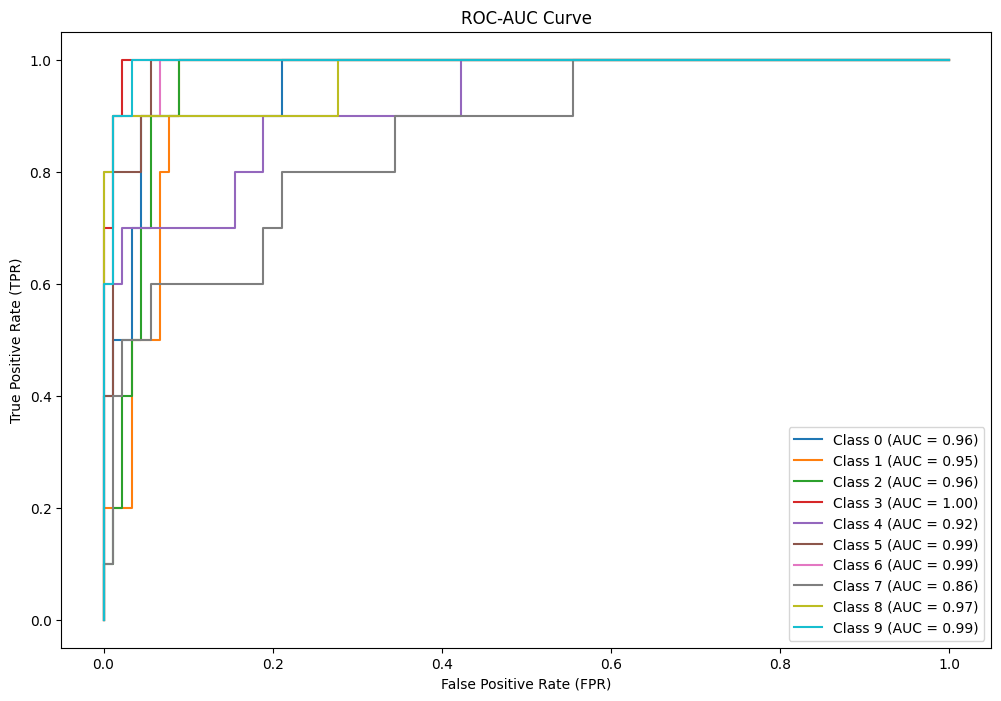

F1 per class:
Class 0 - 0.4615384615384615
Class 1 - 0.5833333333333334
Class 2 - 0.5263157894736842
Class 3 - 0.8
Class 4 - 0.6
Class 5 - 0.75
Class 6 - 0.8235294117647058
Class 7 - 0.380952380952381
Class 8 - 0.8421052631578948
Class 9 - 0.7777777777777777

Precision per class:
Class 0 - 1.0
Class 1 - 0.5
Class 2 - 0.5555555555555556
Class 3 - 0.6666666666666666
Class 4 - 0.6
Class 5 - 0.6428571428571429
Class 6 - 1.0
Class 7 - 0.36363636363636365
Class 8 - 0.8888888888888888
Class 9 - 0.875

Recall per class:
Class 0 - 0.3
Class 1 - 0.7
Class 2 - 0.5
Class 3 - 1.0
Class 4 - 0.6
Class 5 - 0.9
Class 6 - 0.7
Class 7 - 0.4
Class 8 - 0.8
Class 9 - 0.7

ROC-AUC per class:
Class 0 - 0.9622222222222222
Class 1 - 0.9533333333333334
Class 2 - 0.9622222222222222
Class 3 - 0.9955555555555555
Class 4 - 0.921111111111111
Class 5 - 0.9855555555555555
Class 6 - 0.9922222222222222
Class 7 - 0.8588888888888888
Class 8 - 0.971111111111111
Class 9 - 0.9933333333333333
Macro-average ROC-AUC: 0.96


In [70]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc, f1_score


# Calculate precision and recall for each class
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

roc_auc_per_class = []

# Plotting ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(10):
    y_true_binary = (y_true == i).astype(int)
    roc_auc = roc_auc_score(y_true_binary, y_proba[:, i])
    roc_auc_per_class.append(roc_auc)
    fpr, tpr, _ = roc_curve(y_true_binary, y_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_per_class[i]:.2f})')

# Macro average ROC-AUC
roc_auc_macro = np.mean(roc_auc_per_class)

plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

# Output metrics
print("F1 per class:")
for i in range(10):
    print("Class", i, "-", f1[i])
print()

print("Precision per class:")
for i in range(10):
    print("Class", i, "-", precision[i])
print()

print("Recall per class:")
for i in range(10):
    print("Class", i, "-", recall[i])
print()

print("ROC-AUC per class:")
for i in range(10):
    print("Class", i, "-", roc_auc_per_class[i])
    
print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")